# Pre-processing of data

## scanpy analysis

In [1]:
import scanpy as sc
from gtfparse import read_gtf
import pandas as pd

In [2]:
gtf=read_gtf("Mus_musculus.GRCm38.97.gtf.gz").set_index("gene_id")

INFO:root:Extracted GTF attributes: ['gene_id', 'gene_version', 'gene_name', 'gene_source', 'gene_biotype', 'transcript_id', 'transcript_version', 'transcript_name', 'transcript_source', 'transcript_biotype', 'tag', 'transcript_support_level', 'exon_number', 'exon_id', 'exon_version', 'ccds_id', 'protein_id', 'protein_version']


In [3]:
gtf = gtf[~gtf.index.duplicated(keep='first')]

In [4]:
adata=sc.read("adata.h5ad")
adata.var_names=gtf.loc[[n.split(".")[0] for n in adata.var_names]].gene_name.values
adata.var_names_make_unique()

In [5]:
sc.pp.filter_cells(adata,min_genes=200)

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [6]:
adata.var["mt"]=adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata,qc_vars=["mt"],percent_top=None,log1p=None,inplace=True)

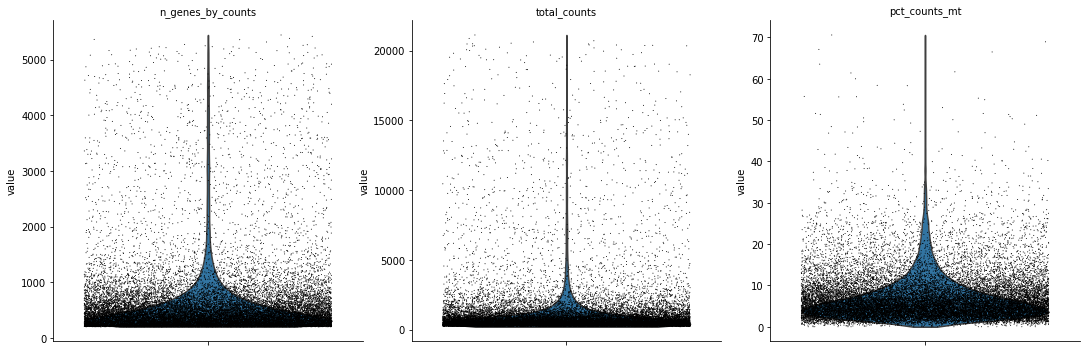

In [7]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [8]:
adata=adata[adata.obs.pct_counts_mt<7.5]

/home/lfaure/miniconda3/envs/bio-gpu-18/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


In [9]:
meta=pd.read_csv("runtable.txt",sep=",",index_col=0)

In [10]:
from glob import glob
meta.loc[[f.split("/")[0] for f in glob("*/*/*.h5ad")],"Tissue"].values

array(['Dorsal root ganglion', 'Dorsal root ganglion',
       'Superior cervical ganglion', 'Dorsal root ganglion',
       'Dorsal root ganglion', 'Dorsal root ganglion',
       'Superior cervical ganglion', 'Superior cervical ganglion',
       'Dorsal root ganglion', 'Superior cervical ganglion',
       'Dorsal root ganglion', 'Dorsal root ganglion',
       'Dorsal root ganglion', 'Superior cervical ganglion',
       'Dorsal root ganglion', 'Dorsal root ganglion'], dtype=object)

In [12]:
adata.obs["location"]=adata.obs.batch.astype(str).replace(adata.obs.batch.cat.categories.tolist(),
                                        meta.loc[[f.split("/")[0] for f in glob("*/*/*.h5ad")],"Tissue"].tolist())

Trying to set attribute `.obs` of view, copying.


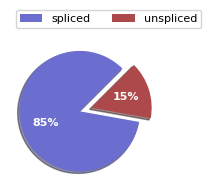

In [13]:
import scvelo as scv
scv.pl.proportions(adata)

In [14]:
sc.pp.filter_genes(adata,min_cells=3)

In [15]:
sc.pp.normalize_total(adata,target_sum=1e3)
sc.pp.log1p(adata)
adata.raw=adata

Finding overdispersed features
    computing mean and variances
    gam fitting
    found 350 over-dispersed features (0:00:01) --> added 
    .var['res'], residuals of GAM fit.
    .var['lp'], p-value.
    .var['lpa'], BH adjusted p-value.
    .var['qv'], percentile of qui-squared distribution.
    .var['highly_variable'], feature is over-dispersed.



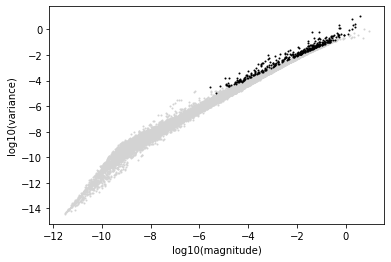

In [16]:
import scFates as scf
scf.pp.find_overdispersed(adata,plot=True)

In [17]:
adata.obsm["X_pca"]=sc.pp.pca(sc.pp.scale(adata[:,adata.var.highly_variable].X.copy(),max_value=10))
sc.pp.neighbors(adata,method="rapids",n_pcs=20,n_neighbors=30)
sc.tl.umap(adata,method="rapids")
sc.tl.leiden(adata,resolution=.3)

... storing 'location' as categorical


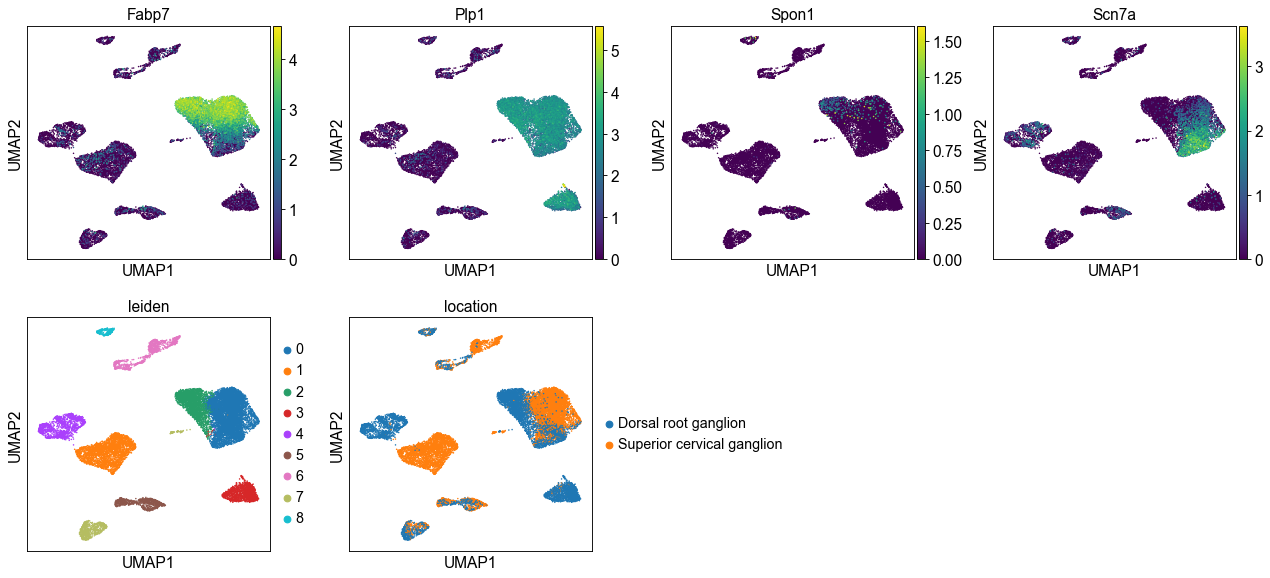

In [18]:
sc.set_figure_params()
sc.pl.umap(adata,color=["Fabp7","Plp1","Spon1","Scn7a","leiden","location"],use_raw=False)

In [19]:
adata.write("adata_processed.h5ad")